<a href="https://colab.research.google.com/github/agrawalreva/idx-exchange-ds34/blob/main/zoe_yip_april_baseline_linear_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal: Predict ClosePrice for single-family residences in California using only features available for off-market homes.


*   Bedrooms Total, BathroomsTotal, LivingArea, GarageSpaces, LotSizeSquareFeet, YearBuilt, Latitude, Longitude, PostalCode, PropertyAge



In [16]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("/content/drive/MyDrive/cleanedCRMLSSold202504.csv")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
df.head()

,MLSAreaMajor,Stories,ViewYN,NewConstructionYN,Levels,PoolPrivateYN,BuyerOfficeAOR,GarageSpaces,LotSizeAcres,LotSizeSquareFeet,...,PropertyType,MlsStatus,ParkingTotal,PropertySubType,CountyOrParish,BedroomsTotal,StateOrProvince,PurchaseContractDate,ContractStatusChangeDate,PostalCode
0,313 - La Quinta South of HWY 111,1.0,False,False,One,False,CaliforniaDesert,2.0,0.4800,20909.0,...,Residential,Closed,2.0,SingleFamilyResidence,Riverside,4.0,CA,2025-04-30,2025-04-30,92253
1,92091 - Rancho Santa Fe,2.0,False,False,Two,False,OrangeCounty,2.0,0.4649,20251.0,...,Residential,Closed,2.0,SingleFamilyResidence,San Diego,3.0,CA,2025-04-30,2025-04-30,92091
2,SO - Sherman Oaks,1.0,False,False,One,False,Southland,1.0,0.1550,6752.0,...,Residential,Closed,1.0,SingleFamilyResidence,Los Angeles,2.0,CA,2025-03-28,2025-04-30,91403
3,92122 - University City,1.0,False,False,"One,Two",False,SanDiego,3.0,0.2008,8747.0,...,Residential,Closed,3.0,SingleFamilyResidence,San Diego,4.0,CA,2025-04-01,2025-04-14,92122
4,SE - San Clemente Southeast,2.0,False,False,Two,False,Laguna,3.0,0.4132,18000.0,...,Residential,Closed,8.0,SingleFamilyResidence,Orange,3.0,CA,2025-01-29,2025-04-29,92672


In [18]:
df.columns

Index(['MLSAreaMajor', 'Stories', 'ViewYN', 'NewConstructionYN', 'Levels',
       'PoolPrivateYN', 'BuyerOfficeAOR', 'GarageSpaces', 'LotSizeAcres',
       'LotSizeSquareFeet', 'LotSizeArea', 'BuyerOfficeName',
       'BuyerAgentFirstName', 'BuyerAgentMlsId', 'StreetNumberNumeric',
       'UnparsedAddress', 'City', 'YearBuilt', 'FireplaceYN',
       'BuyerAgentLastName', 'LivingArea', 'Latitude', 'Longitude',
       'BuyerAgentAOR', 'BathroomsTotalInteger', 'ClosePrice', 'CloseDate',
       'PropertyType', 'MlsStatus', 'ParkingTotal', 'PropertySubType',
       'CountyOrParish', 'BedroomsTotal', 'StateOrProvince',
       'PurchaseContractDate', 'ContractStatusChangeDate', 'PostalCode'],
      dtype='object')

Let's create a new DataFrame for relevant predictors (features only available for off-market homes)

In [19]:
df['PropertyAge'] = 2025 - df['YearBuilt']
features = ['BedroomsTotal', 'BathroomsTotalInteger', 'LivingArea', 'GarageSpaces', 'LotSizeSquareFeet', 'YearBuilt', 'Latitude', 'Longitude', 'PostalCode', 'PropertyAge']
df = df[features + ['ClosePrice']].copy()
df.head()

,BedroomsTotal,BathroomsTotalInteger,LivingArea,GarageSpaces,LotSizeSquareFeet,YearBuilt,Latitude,Longitude,PostalCode,PropertyAge,ClosePrice
0,4.0,5.0,4154.0,2.0,20909.0,2018.0,33.651150,-116.244673,92253,7.0,2700000.0
1,3.0,4.0,3104.0,2.0,20251.0,2004.0,33.057843,-117.182771,92091,21.0,3250000.0
2,2.0,2.0,1265.0,1.0,6752.0,1951.0,34.155882,-118.451233,91403,74.0,1275000.0
3,4.0,3.0,3070.0,3.0,8747.0,1984.0,32.850572,-117.187512,92122,41.0,1701000.0
4,3.0,3.0,3025.0,3.0,18000.0,1977.0,33.418740,-117.588871,92672,48.0,1750000.0


In [20]:
df.isna().sum()

,0
BedroomsTotal,0
BathroomsTotalInteger,0
LivingArea,0
GarageSpaces,0
LotSizeSquareFeet,0
YearBuilt,0
Latitude,0
Longitude,0
PostalCode,0
PropertyAge,0


Postal codes are categorical -- let's use LabelEncoder to normalize labels, transform non-numerical labels to numerical labels.

In [21]:
le = LabelEncoder()
df['PostalCode'] = le.fit_transform(df['PostalCode'].astype(str))

Now lets look at the different features' relationships with ClosePrice (bivariate).

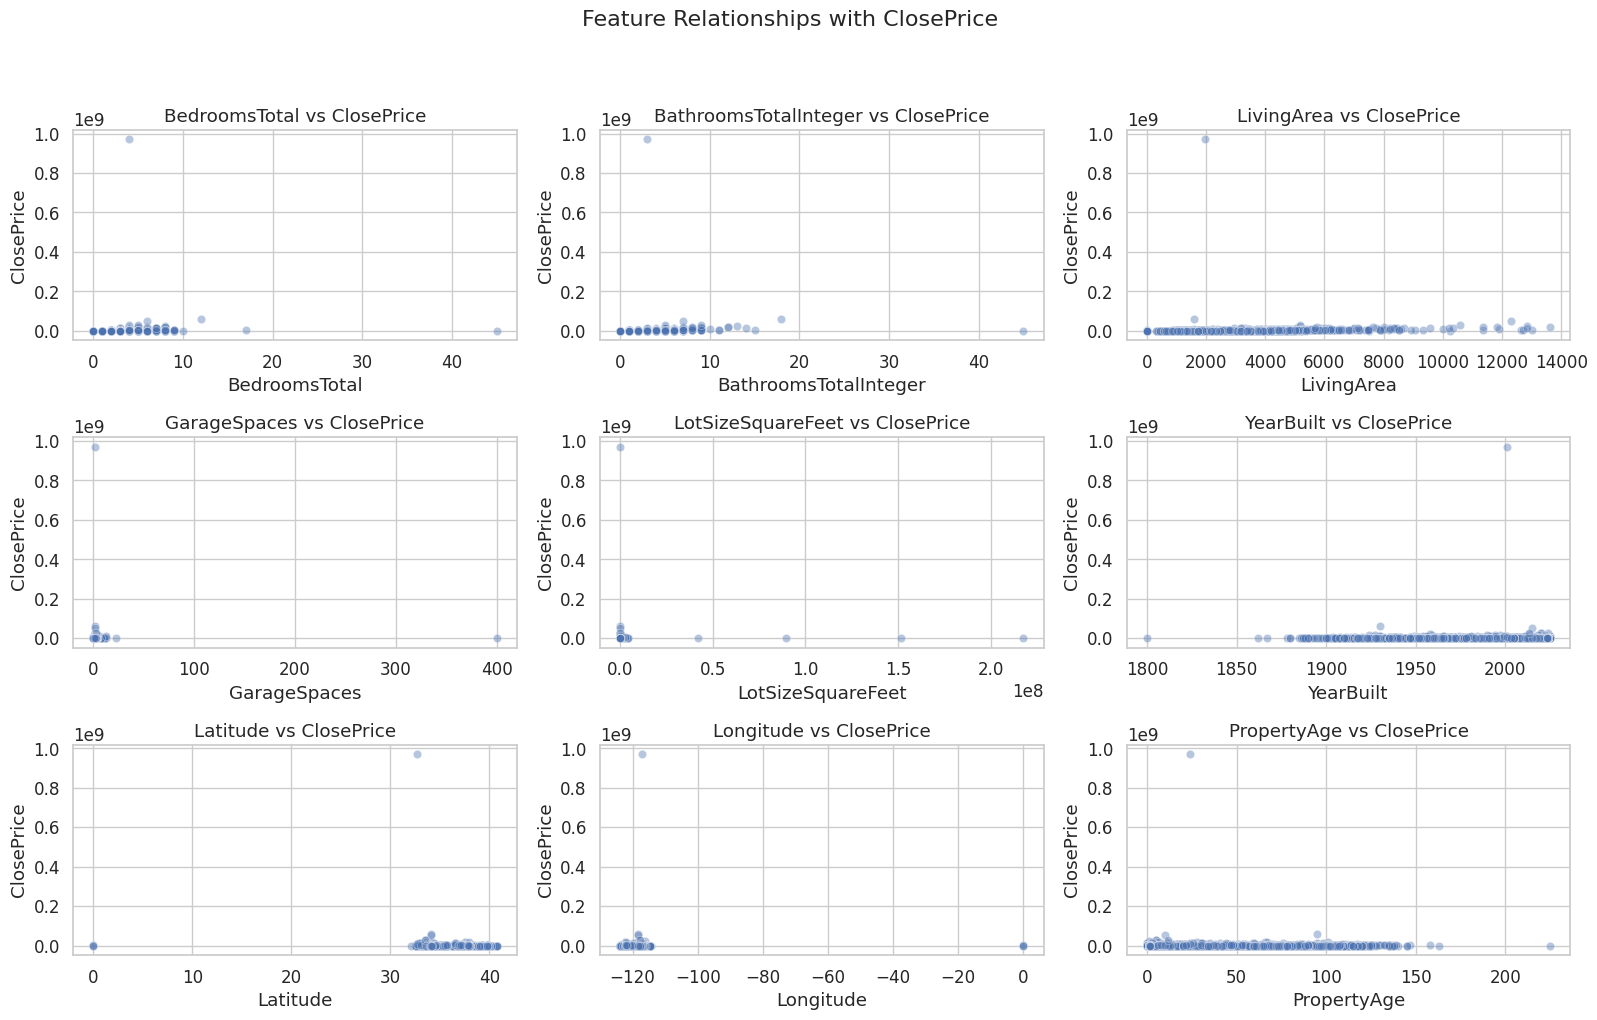

In [26]:
# Set plotting style
sns.set(style='whitegrid', context='notebook', font_scale=1.1)

# Numeric columns to analyze
numeric_cols = [
    'BedroomsTotal', 'BathroomsTotalInteger', 'LivingArea', 'GarageSpaces',
    'LotSizeSquareFeet', 'YearBuilt', 'Latitude', 'Longitude', 'PropertyAge'
]

target = 'ClosePrice'

plt.figure(figsize=(16, 10))
for i, feature in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df, x=feature, y=target, alpha=0.4)
    plt.title(f"{feature} vs {target}")
plt.suptitle("Feature Relationships with ClosePrice", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

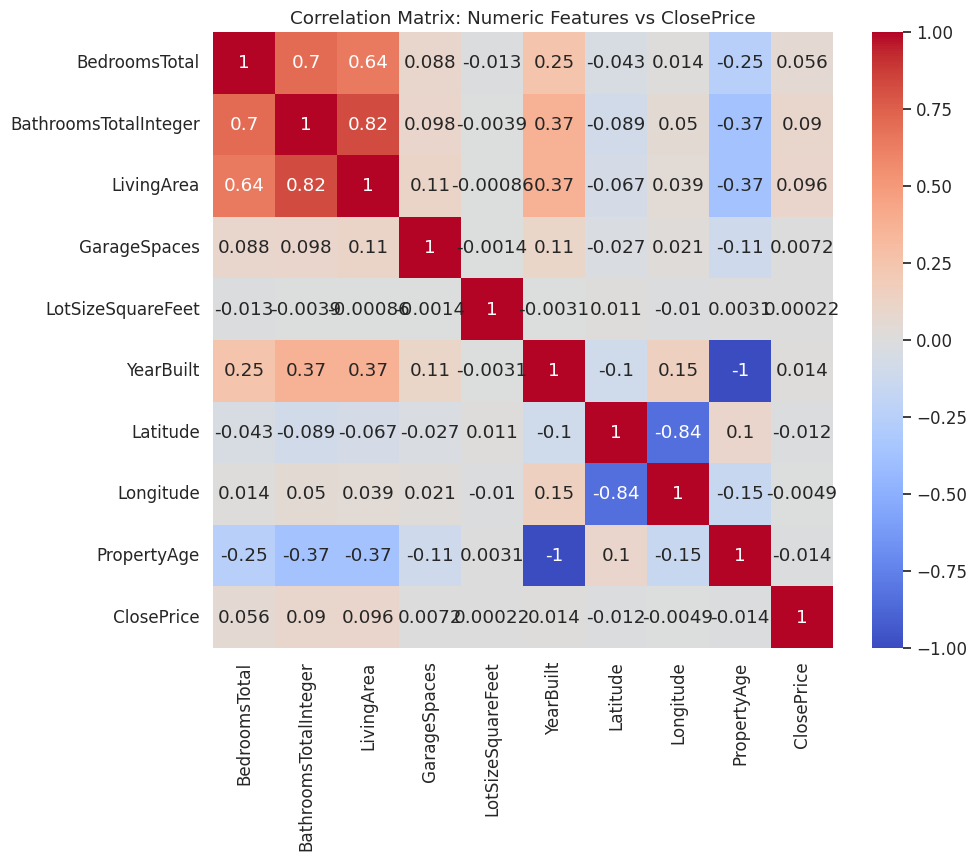

In [27]:
#Correlation heatmap — quick overview of linear relationships
plt.figure(figsize=(10, 8))
corr = df[numeric_cols + [target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Numeric Features vs ClosePrice")
plt.show()

Next, let's split data into training and testing.

In [35]:
X = df.drop('ClosePrice', axis = 1)
y = df['ClosePrice']
#Log-transform target to reduce skew
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, random_state = 42)
#Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now, we build our linear regression baseline.

In [36]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

y_test_exp = y_test
y_pred_exp = y_pred

r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100

print("R²:", r2)
print("MAPE:", mape)
print("MdAPE:", mdape)

R²: 0.08773152181569854
MAPE: 54.625321349246015
MdAPE: 36.15553924775696


In [37]:
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance (Linear Coefficients):")
print(coef_df)


Feature Importance (Linear Coefficients):
                 Feature    Coefficient
2             LivingArea  690337.266434
1  BathroomsTotalInteger  481403.300784
8             PostalCode   99384.788381
9            PropertyAge   96396.784428
4      LotSizeSquareFeet    3829.301971
5              YearBuilt  -96396.784428
3           GarageSpaces  -97320.826625
0          BedroomsTotal -218657.774405
7              Longitude -467015.854716
6               Latitude -548417.814058


Residual and Prediction Diagnostics

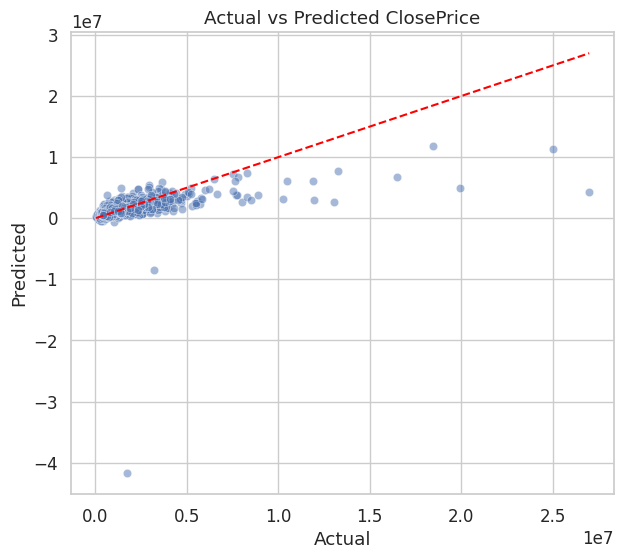

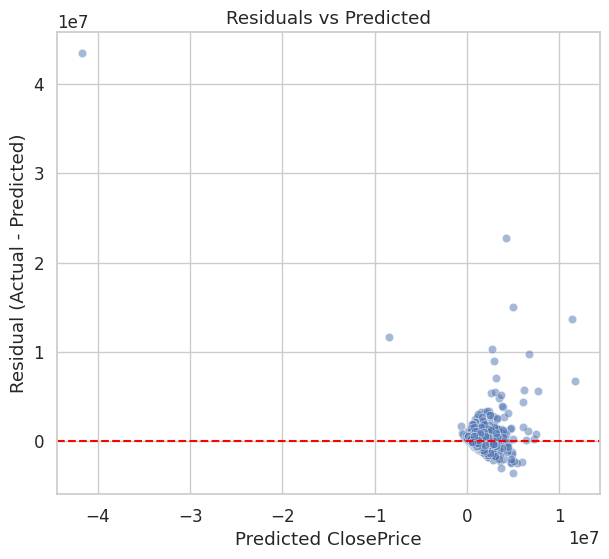

In [38]:
if 'y_test_exp' in locals() and 'y_pred_exp' in locals():
    # Actual vs Predicted
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_test_exp, y=y_pred_exp, alpha=0.5)
    plt.plot([y_test_exp.min(), y_test_exp.max()],
             [y_test_exp.min(), y_test_exp.max()],
             color='red', linestyle='--')
    plt.title("Actual vs Predicted ClosePrice")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    # Residuals
    residuals = y_test_exp - y_pred_exp
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_pred_exp, y=residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted ClosePrice")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.show()

Linear regression is not too good in predicting ClosePrice --> move to XGBoost